# 泰坦尼克号生存问题



一、问题以及数据集简介
--
### 1.问题概述
1912年4月10日，泰坦尼克号展开首航，也是唯一一次的载客出航，最终目的地为纽约。

部分乘客为当时世界上顶级富豪，以及许多来自英国、爱尔兰、斯堪的纳维亚和欧洲其他地区的移民，他们寻求在美国展开新生活的机会。

4月15日在中途发生擦撞冰山后沉没的严重灾难。2,224名船上人员中有1,514人罹难，成为近代史上最严重的和平时期船难。船长爱德华·约翰·史密斯最终与船一起沉没；泰坦尼克号总设计师托马斯·安德鲁斯也在这起灾难中死亡。
### 2.数据集简介
该数据集来自kaggle平台，也是该平台machine learning竞赛的入门赛题。

该比赛需要使用机器学习来创建一个模型来预测哪些乘客能够从这场灾难中幸存下来。

以下是本模型全流程中会使用到的包


In [1]:
# 导包
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as seaborn
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing, model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

二、数据集分析
--


### 1.数据集基本概况预览

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
————————————————这里是分界线——————————————————
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passenger

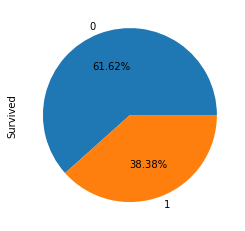

In [2]:
#导入数据

train_data = pd.read_csv('titanic_train.csv')
test_data = pd.read_csv('titanic_test.csv')
train_data.info()
print('————————————————这里是分界线——————————————————')
test_data.info()
print()
print("——————————————存活下来的人数比例———————————————")
train_data['Survived'].value_counts().plot.pie(autopct = '%1.2f%%')

通过**info()**方法获取数据集的基本信息，不难看出特征值**Age、Cabin、Embarked和Fare**存在缺失值。

这些缺失值需要得到妥善处理。


### 2.缺失值处理
#### （1）对于年龄的处理

年龄的缺失可以使用平均数代替，但年龄具有很重要的预测价值，因此其准确性很重要，故这里使用随机森林模型对年龄数据集进行处理。


In [3]:
age = train_data[['Age','Survived','Fare', 'Parch', 'SibSp', 'Pclass']]
# 分别选取出为空行和不为空行
age_notnull = age.loc[(train_data['Age'].notnull())]
age_null = age.loc[(train_data['Age'].isnull())]
# 将不为空的上述特征制作为训练集
x = age_notnull.values[:,1:]
y = age_notnull.values[:,0]

# 建立随机森林模型训练并进行预测,这里选择2000个随机树且开启并行计算，加快处理速度
rf = RandomForestRegressor(n_estimators=2000,n_jobs=-1)
rf.fit(x,y)
# 预测
pd_Ages = rf.predict(age_null.values[:,1:])
# 写入
train_data.loc[train_data['Age'].isnull(), ['Age']] = pd_Ages
# # 查看是否补充完整
# train_data.info()


#### （2）对于船舱号的处理

缺失可能表示乘客并没有对应的船舱，故这里把船舱号缺失的部分赋上缺失值NONE表示该船舱号缺失



In [4]:
train_data['Cabin'] = train_data.Cabin.fillna('NONE')


#### （3）上船位置（Embarked）的处理

上船位置一共有三个，且仅缺失了两个值，故可采取众数的方式进行处理



In [5]:
train_data.Embarked[train_data.Embarked.isnull()] = train_data.Embarked.dropna().mode().values


最后查看补充后的结果

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### 3.数据集分析


#### （1）首先是船舱等级（Pclass）与生存之间是否存在联系

在数据集中，船舱共分为了三个等级——1，2，3. 故可做：

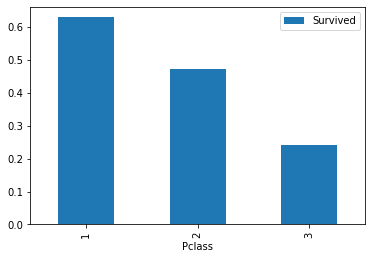

In [7]:
train_data[['Pclass','Survived']].groupby(['Pclass']).mean().plot.bar()

不难看出船舱等级越靠前，其生存率也越高。

#### （2）性别（Sex）与生存率之间的联系

在电影《泰坦尼克号》中，可以看到，船员们将救生衣与救生艇优先提供给了老人、妇女和孩子们，可以猜测后续应该是女性的存活率相较于男性更高一些。

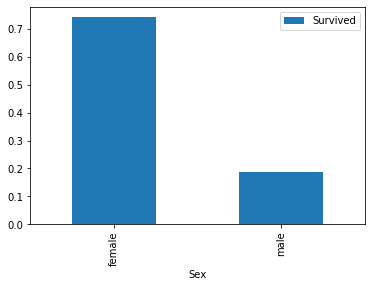

In [8]:
train_data[['Sex','Survived']].groupby(['Sex']).mean().plot.bar()

结果如我们所料，女性的生存概率远大于男性。

结合上一个对船舱的分析，将二者结合进行再次分析有：

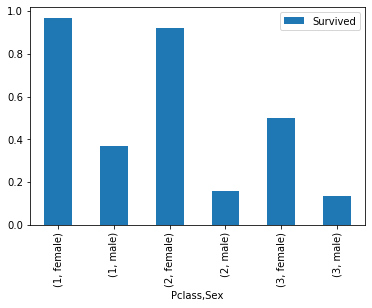

In [9]:
train_data[['Sex','Pclass','Survived']].groupby(['Pclass','Sex']).mean().plot.bar()


整体上，各个船舱均是女性生还率较高，男性生还率相对较低，但不同船舱的生还率存在差异。

#### （3）年龄（Age）与生存率之间的关系

可以初步进行推测，在面对求生的环境下，是体格强壮的中青年人更具有生存能力，还是说获得了救生衣或救生船的老人孩子获救更多。

这里我们先结合前面已经分析过的部分进行分析

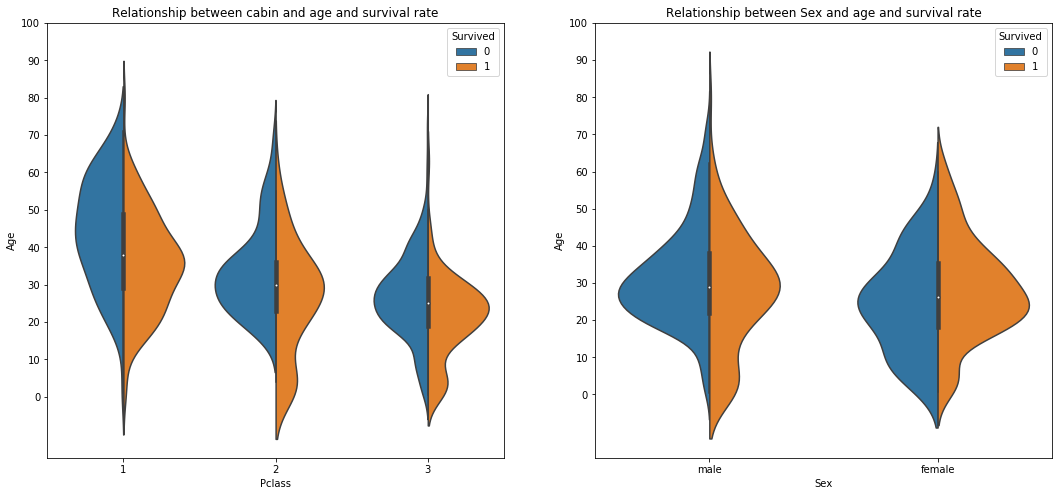

In [10]:
# 这里结合前面的性别和船舱位置进行分析，故在一个图层上创建两个图表，这里用到subplot方法：
# 创建一个1 X 2 的图表矩阵（就是并排放置两个图表）,图表长宽比为9：4
fig, ax = plt.subplots(1,2,figsize = (18,8))
# 使用seaborn中的小提琴图（violinplot）进行图表的绘制
# 船舱、年龄与生存率之间的关系，使用不同颜色在两边绘制
seaborn.violinplot('Pclass','Age',hue='Survived',data=train_data,split=True,ax=ax[0])

ax[0].set_title('Relationship between cabin and age and survival rate')
# 设置y轴从0-100以10为步长
ax[0].set_yticks(range(0,110,10))

# 同样的方式再来一次，只是这次是和性别进行联系
seaborn.violinplot('Sex','Age',hue='Survived',data=train_data,split=True,ax = ax[1])

ax[1].set_title('Relationship between Sex and age and survival rate')
# 设置y轴从0-100以10为步长
ax[1].set_yticks(range(0,110,10))

plt.show()



这里我们看到，1号船舱中，30-40层次的存活人群相对较多；2号船舱中则是35-25岁的人群幸存数相对较多，但其死亡率也相对较高；3号船舱情况与2号船舱类似，但年龄结构整体微向下移动。

右侧图可知，整体与性别分析结果相同，但可以关注到一个有趣的点，20岁以下的男性生存率明显高于女性，但我未能查询到这一现象出现的相关解释，只能猜测，可能是女孩子本身就不太多，未能幸存的占比高于幸存下来的女孩子。

接下来的是对单年龄数据进行分析：


首先是年龄分布结构


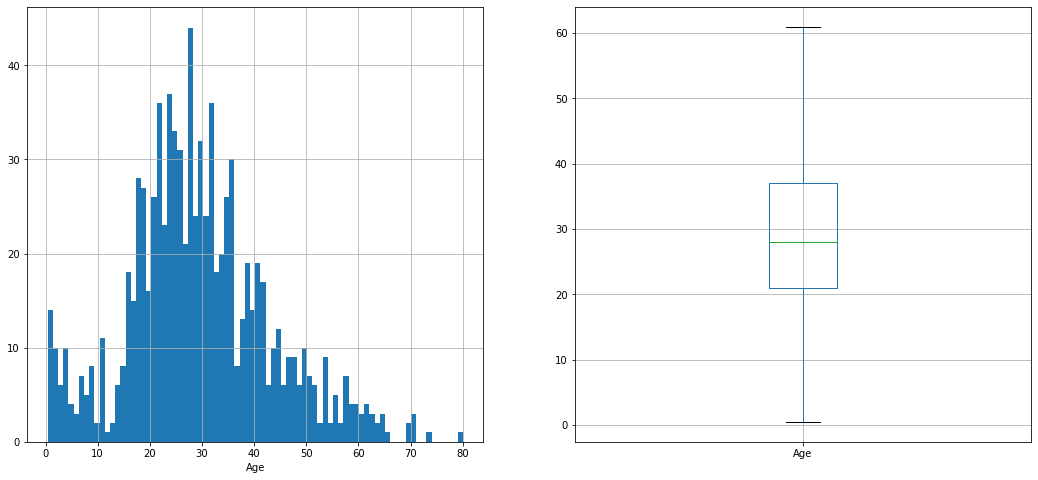

count    891.000000
mean      29.654917
std       13.738240
min        0.420000
25%       21.000000
50%       28.000000
75%       37.000000
max       80.000000
Name: Age, dtype: float64

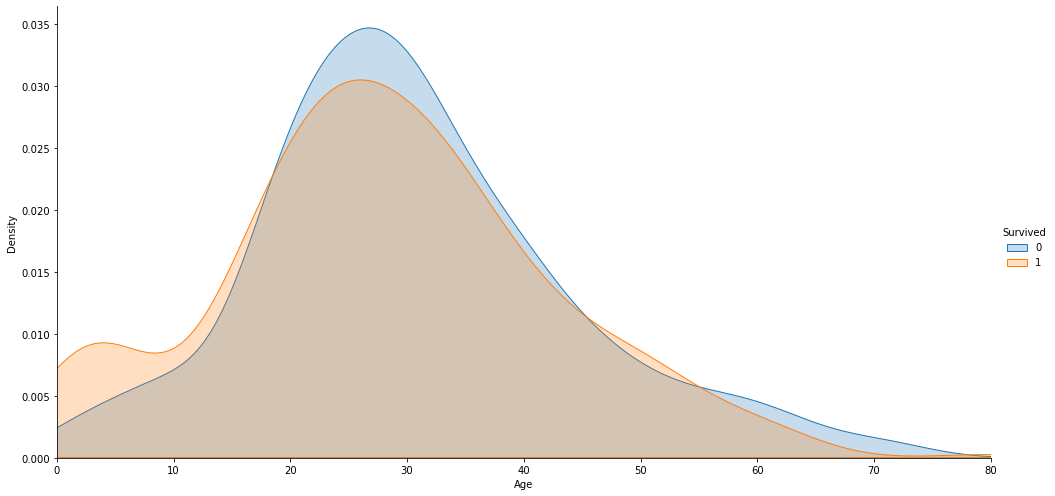

In [11]:
plt.figure(figsize=(18,8))
# 创建一行两列的图表，目前定位为第一张图（左图）
plt.subplot(121)
# 用age绘制直方图，设置80个直方
train_data['Age'].hist(bins=80)
plt.xlabel('Age')

# 箱线图
plt.subplot(122)
train_data.boxplot(column='Age', showfliers=False)
plt.show()

# 年龄生还分布：
facet = seaborn.FacetGrid(train_data, hue="Survived",size=7,aspect=2)  # 设置图片纵横比为2
facet.map(seaborn.kdeplot,'Age',shade= True)    # 使用seaborn.kdeplot（单变量核密度估计值）方法绘制
facet.set(xlim=(0, train_data['Age'].max()))    # 在图集上设置属性，设置范围为z轴从0到年龄的最大值
facet.add_legend()

#基本内容描述：
train_data['Age'].describe()

可见，船上人员年龄集中分布在20-40岁，18岁以下的未成年人相较死亡率，其存活比例更高一些。


之后是分群体分析

依据年龄，将乘客分为未成年人、青年人、中年人和老年人

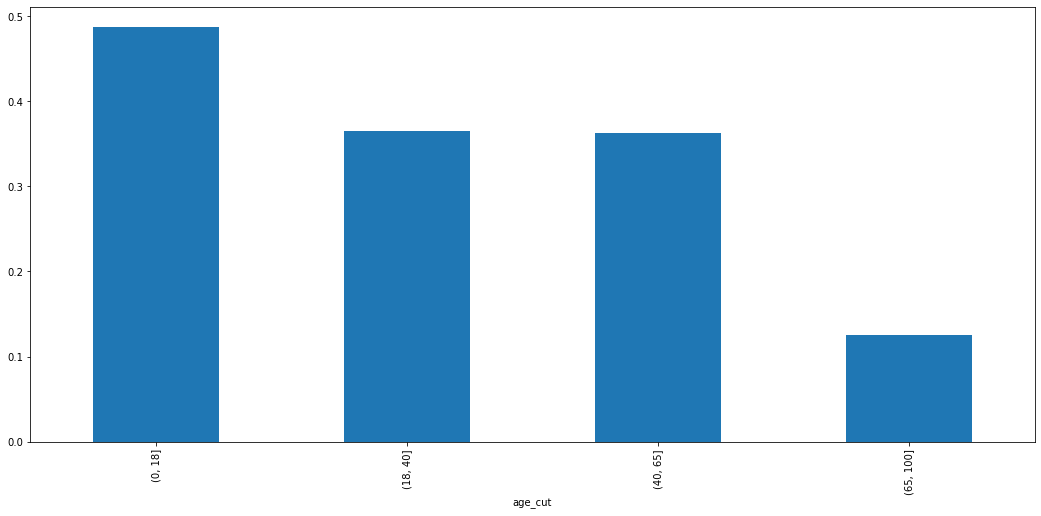

In [12]:
age_list = [0,18,40,65,100]
train_data['age_cut'] = pd.cut(train_data['Age'],age_list)  #在dataset中创建划分标识，依据age_list来进行年龄的划分
age_GroupAnalysis = train_data.groupby('age_cut')['Survived'].mean()
age_GroupAnalysis.plot(kind='bar',figsize=(18,8))

由图表可见，未成年人在这次灾难的存活率最高，中年人和青年人几乎相同并且紧随其后，老年人生存率相对较低。



#### （4）亲人（Parch&SibSp）与生存率之间的关系

我们可以姑且推测，在有亲人的前提下，可能会激发一些人的生存欲，幸存的概率随之增加。

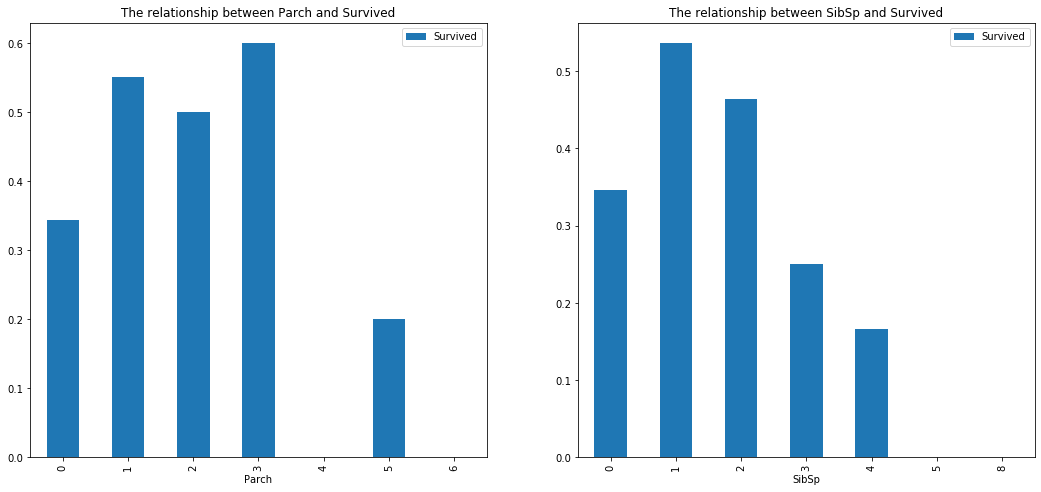

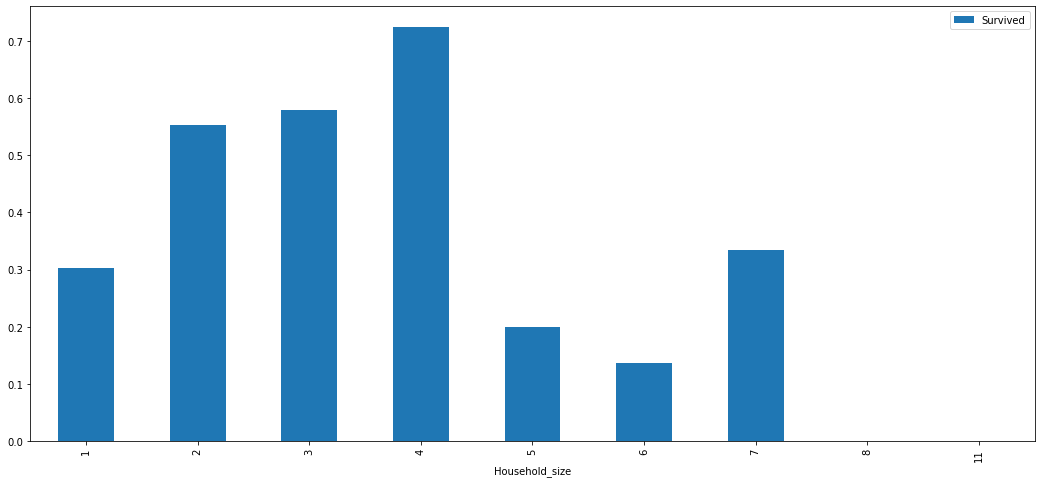

In [13]:
# 同样的，绘制两个表，左边是有无父母子女（Parch）对生存率的影响，右侧是有无兄弟姐妹（SibSp）对生存率的影响
fig,ax=plt.subplots(1,2,figsize=(18,8))
train_data[['Parch','Survived']].groupby(['Parch']).mean().plot.bar(ax=ax[0])
ax[0].set_title('The relationship between Parch and Survived')
train_data[['SibSp','Survived']].groupby(['SibSp']).mean().plot.bar(ax=ax[1])
ax[1].set_title('The relationship between SibSp and Survived')

# 之后我们将这两个数值进行合并得到“家庭规模”（Household_size）
train_data['Household_size'] = train_data['Parch'] + train_data['SibSp'] + 1
train_data[['Household_size','Survived']].groupby(['Household_size']).mean().plot.bar(figsize=(18,8))

相较于有家庭成员的人们，其生存率相对高于没有家庭成员的人们，但是如果家庭成员过多，就成了求生路上的阻碍，反倒不利于生存。

#### （5）港口与生存率之间的关系

泰坦尼克号的航线为：从南安普顿港口出发，其中途径瑟堡和爱尔兰昆士敦，那么早上船的人有可能在这场灾难发生之前下船，因此二者应该存在一定的相关性。

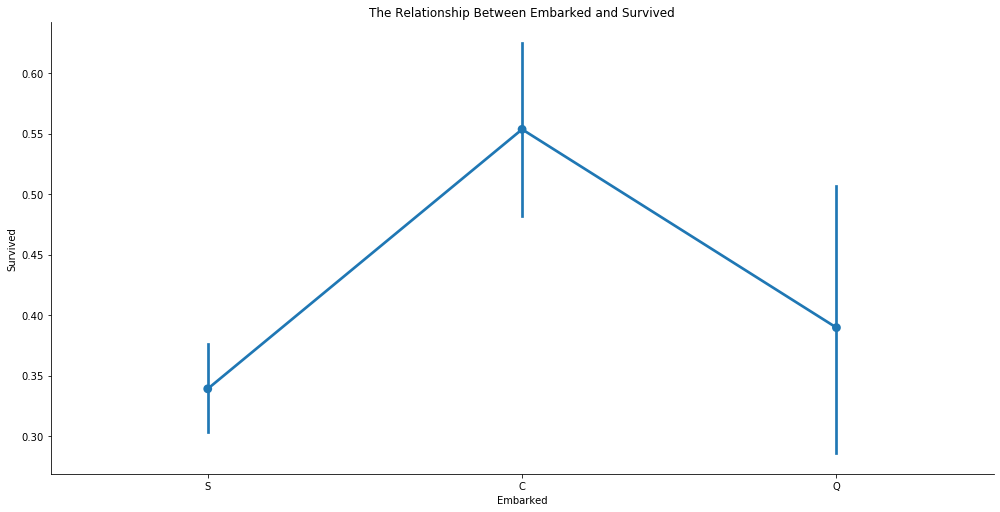

In [14]:
seaborn.factorplot('Embarked','Survived',data=train_data,size=7,aspect=2)
plt.title('The Relationship Between Embarked and Survived')
plt.show()


由上图可以看出，在C港口上船的人生存率最高，Q港口其次，最低的是S港口

至此，第二部分数据集分析结束。数据集剩下的未使用的数据，像乘客编号，其对分析不存在影响，在后续操作可以删除。

网上查阅到的相关资料可以得知，姓名也对生存率有一定影响，主要体现在称呼上面（能够体现社会地位），但船舱号其实就已经可以做到这一点，因此这里我们不考虑姓名这一点,将其放在“特征提取”中处理。

船票号过于杂乱，几乎没有什么规律可言，这里同样不考虑；船票费用和上面的原因相似，将被放在变量转换中处理，这里不再分析。

## 三、数据预处理

### 1.缺失值处理
已在第二部分完成，这里不再赘述

### 2.变量转换
由于本文档使用的均是来自于skleran库中的函数，而其均需要numeric型数据，因此需要将部分原始数据进行转换。

In [15]:
# 首先需要将港口号（Embarked）进行哑变量处理：
EmbarkedByDummies = pd.get_dummies(train_data['Embarked'])
# 将处理后的内容传至数据集中
train_data = train_data.join(EmbarkedByDummies)
#去除原先的港口号内容
train_data.drop(['Embarked'], axis=1,inplace=True)
EmbarkedByDummies = train_data[['S','C','Q']]

#对于船舱号，可以使用factorize()方法进行处理
'''
factorize函数可以将Series中的标称型数据映射称为一组数字，相同的标称型映射为相同的数字。factorize函数的返回值是一个tuple（元组），
元组中包含两个元素。第一个元素是一个array，其中的元素是标称型元素映射为的数字；第二个元素是Index类型，其中的元素是所有标称型元素，没有重复。
'''
train_data['CabinByFactorize'] = train_data['Cabin'].map( lambda x : re.compile("([a-zA-Z]+)").search(x).group())
# convert the distinct cabin letters with incremental integer values
train_data['CabinByFactorize'] = pd.factorize(train_data['CabinByFactorize'])[0]

# train_data['CabinByFactorize'].head()

# 年龄的映射
'''
由于年龄分布范围相对较广，这里可以利用Scaling函数将大范围数值映射到小范围，
从而避免大范围数值特征将会有更高的权重
'''


assert np.size(train_data['Age']) == 891
# 数据太多，只能用（-1，1）范围
scaler = preprocessing.StandardScaler()
train_data['AgeByScaler'] = scaler.fit_transform(train_data['Age'].values.reshape(-1, 1))
# train_data['AgeByScaler'].head()

# 对船票数据需要先进行离散化处理（Binning），后续再进行哑变量处理，方便后续模型运行
train_data['Fare_bin'] = pd.qcut(train_data['Fare'], 5)
# train_data['Fare_bin'].head()
# 将数据的哑变量传入data中
train_data['Fare_bin_id'] = pd.factorize(train_data['Fare_bin'])[0]
#使用concat方法将二者拼接在一起
fare_bin_dummies_df = pd.get_dummies(train_data['Fare_bin']).rename(columns=lambda x: 'Fare_' + str(x))
train_data = pd.concat([train_data, fare_bin_dummies_df], axis=1)



### 3.特征提取
该部分需要对测试集数据缺失值进行补充处理，同时需要将测试数据集和训练数据一同处理，使得二者具有相同的数据类型。



In [16]:
#导入数据
train_feature = pd.read_csv('titanic_train.csv')
test_feature = pd.read_csv('titanic_test.csv')
test_feature['Survived'] = 0
# 将训练和预测数据合为一体进行处理
unity = train_feature.append(test_feature)
PassengerId = test_feature['PassengerId']

# Embarked属性，参考第二部分的处理方法，这里依旧用众数来填充
unity['Embarked'].fillna(unity['Embarked'].mode().iloc[0], inplace=True)
# 依据上面的变量转换处理方法：
unity['Embarked'] = pd.factorize(unity['Embarked'])[0]

# 使用 pd.get_dummies 获取one-hot 编码
emb_dummies = pd.get_dummies(unity['Embarked'], prefix=unity[['Embarked']].columns[0])
unity = pd.concat([unity, emb_dummies], axis=1)

# 性别处理，同样使用one-hot编码（dummy）:
unity['Sex'] = pd.factorize(unity['Sex'])[0]

sex_dummies_df = pd.get_dummies(unity['Sex'], prefix=unity[['Sex']].columns[0])
unity = pd.concat([unity, sex_dummies_df], axis=1)


unity['Title'] = unity['Name'].map(lambda x:re.compile(", (.*?)\.").findall(x)[0])

# 对名称进行统一化处理：
title_Dict = {}
title_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
title_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
title_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
title_Dict.update(dict.fromkeys(['Master','Jonkheer'], 'Master'))
unity['Title'] = unity['Title'].map(title_Dict)

# 同样对称呼使用哑变量处理，对不同称呼进行分列：
unity['Title'] = pd.factorize(unity['Title'])[0]

title_dummies = pd.get_dummies(unity['Title'],prefix=unity[['Title']].columns[0])
unity = pd.concat([unity,title_dummies],axis=1)

# Fare的处理
# Fare在测试数据中缺少一个值，还是用均价进行填充
# 照一二三等舱各自的均价来填充,下面transform将函数np.mean应用到各个group中。
unity['Fare'] = unity[['Fare']].fillna(unity.groupby('Pclass').transform(np.mean))

# 在对票号进行处理的时候发现部分票号数据有重复，根据名字姓氏可得，里面存在团体票，因此需要将票价进行平摊

unity['group_ticket'] = unity['Fare'].groupby(by=unity['Ticket']).transform('count')
unity['Fare'] = unity['Fare']/unity['group_ticket']
unity.drop(['group_ticket'],axis=1,inplace=True)

# 使用binning给票价分等级，然后用哑变量分列：
unity['Fare_bin'] = pd.qcut(unity['Fare'],5)
# 分类
unity['Fare_bin_id'] = pd.factorize(unity['Fare_bin'])[0]

fare_bin_dummies_df = pd.get_dummies(unity['Fare_bin_id']).rename(columns=lambda x: 'Fare_' + str(x))
unity = pd.concat([unity, fare_bin_dummies_df], axis=1)
unity.drop(['Fare_bin'], axis=1, inplace=True)

# Pclass 转换为哑变量

pclass_dummies = pd.get_dummies(unity['Pclass']).rename(columns=lambda x: 'Pclass_' + str(x))
unity = pd.concat([unity,pclass_dummies],axis=1)
unity['Pclass'] = pd.factorize(unity['Pclass'])[0]

# 将Parch和SibSp合并为family
def family_size_category(family_size):
    if family_size <= 1:
        return 'Single'
    elif family_size <= 4:
        return 'Small_Family'
    else:
        return 'Large_Family'

unity['Family_Size'] = unity['Parch'] + unity['SibSp'] + 1
unity['Family_Size_Category'] = unity['Family_Size'].map(family_size_category)

le_family = LabelEncoder()
le_family.fit(np.array(['Single', 'Small_Family', 'Large_Family']))
unity['Family_Size_Category'] = le_family.transform(unity['Family_Size_Category'])

family_size_dummies = pd.get_dummies(unity['Family_Size_Category'],
                                     prefix=unity[['Family_Size_Category']].columns[0])
unity = pd.concat([unity, family_size_dummies], axis=1)

# 年龄的处理，可以按照处理训练集的方法进行处理：
age = unity[['Age','Embarked','Fare', 'Sex','Family_Size', 'Pclass','Title']]
# 分别选取出为空行和不为空行
age_notnull = age.loc[(unity['Age'].notnull())]
age_null = age.loc[(unity['Age'].isnull())]
# 将不为空的上述特征制作为训练集
x = age_notnull.values[:,1:]
y = age_notnull.values[:,0]

# 建立随机森林模型训练并进行预测,这里选择2000个随机树且开启并行计算，加快处理速度
rf = RandomForestRegressor(n_estimators=2000,n_jobs=-1)
rf.fit(x,y)
# 预测
pd_Ages = rf.predict(age_null.values[:,1:])
# 写入
unity.loc[unity['Age'].isnull(), ['Age']] = pd_Ages



# 对Ticket数据的处理
unity['Ticket_Letter'] = unity['Ticket'].str.split().str[0]
unity['Ticket_Letter'] = unity['Ticket_Letter'].apply(lambda x: 'U0' if x.isnumeric() else x)

# 将 Ticket_Letter factorize
unity['Ticket_Letter'] = pd.factorize(unity['Ticket_Letter'])[0]

# 对Cabin数据进行填充，将空缺的部分换成NONE：
unity.loc[unity.Cabin.isnull(), 'Cabin'] = 'NONE'
unity['Cabin'] = unity['Cabin'].apply(lambda x: 0 if x == 'NONE' else 1)

# 查看处理后的数据
unity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PassengerId             1309 non-null   int64  
 1   Survived                1309 non-null   int64  
 2   Pclass                  1309 non-null   int64  
 3   Name                    1309 non-null   object 
 4   Sex                     1309 non-null   int64  
 5   Age                     1309 non-null   float64
 6   SibSp                   1309 non-null   int64  
 7   Parch                   1309 non-null   int64  
 8   Ticket                  1309 non-null   object 
 9   Fare                    1309 non-null   float64
 10  Cabin                   1309 non-null   int64  
 11  Embarked                1309 non-null   int64  
 12  Embarked_0              1309 non-null   uint8  
 13  Embarked_1              1309 non-null   uint8  
 14  Embarked_2              1309 non-null   u

可以看到，所有的特征值均已提取完毕。

### 4.特征间相关性分析

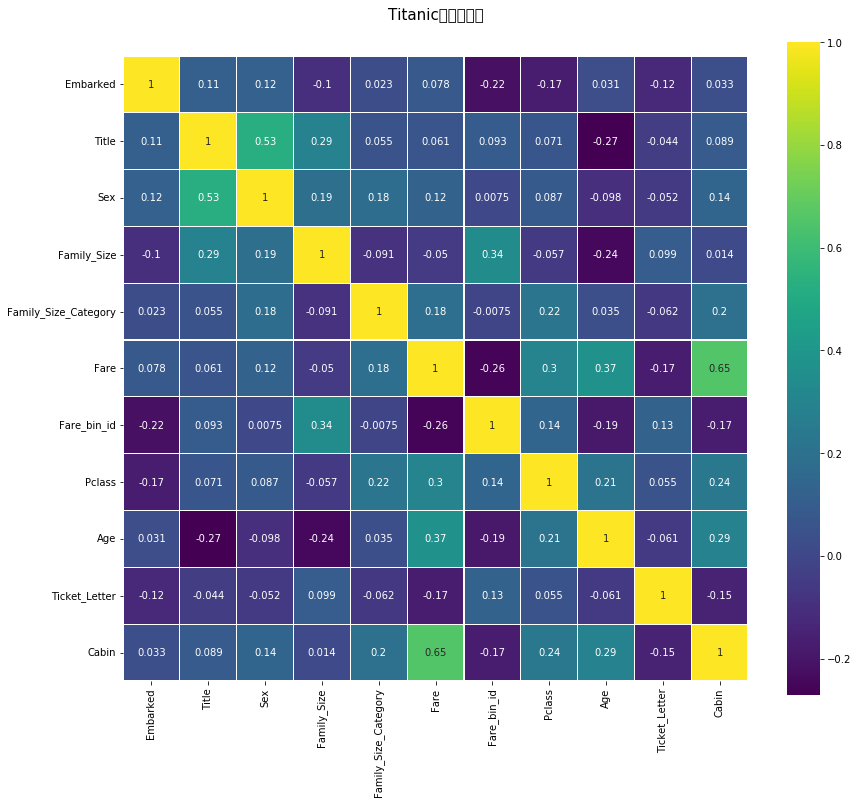

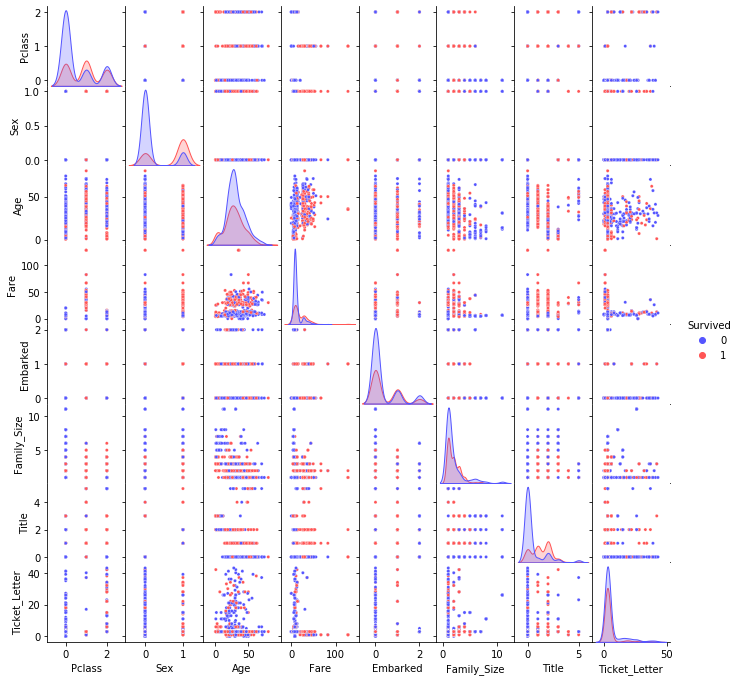

In [17]:
# 数据准备
Correlation = pd.DataFrame(unity[['Embarked', 'Title', 'Sex', 'Family_Size', 'Family_Size_Category', 'Fare', 'Fare_bin_id', 'Pclass', 'Age', 'Ticket_Letter', 'Cabin']])

# 绘制相关性热图
colormap = plt.cm.viridis
plt.figure(figsize=(14, 12))
plt.title("Titanic特征相关性", y=1.05, size=15)
seaborn.heatmap(Correlation.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

# 去除重复的索引行
unity = unity[~unity.index.duplicated()]

# 绘制 Pairplot
g = seaborn.pairplot(unity[['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Family_Size', 'Title', 'Ticket_Letter']], hue='Survived', palette='seismic', height=1.2, diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))

# 调整布局以隐藏 x 轴标签
g.fig.subplots_adjust(wspace=0, hspace=0)

# 显示图形
plt.show()

### 5.输入模型前的准备工作
age与fare数据需要进行正则化处理、去除特征值、将训练集和测试集分离

In [18]:
# 对age和fare进行正则化
scale_age_fare = preprocessing.StandardScaler().fit(unity[['Age','Fare']])
unity[['Age','Fare']] = scale_age_fare.transform(unity[['Age','Fare']])

# 去除已经提取过的或者无用特征：
# 首先先备份
unity_backup = unity
# unity.info()
# 去掉特征值
unity.drop(['PassengerId', 'Embarked', 'Sex', 'Name', 'Title', 'Fare_bin_id',
                       'Parch', 'SibSp', 'Family_Size_Category', 'Ticket'],axis=1,inplace=True)
# unity.info()
# 训练与测试数据分离
train_data = unity[:891]
test_data = unity[891:]

titanic_train_data_X = train_data.drop(['Survived'],axis=1)
titanic_train_data_Y = train_data['Survived']
titanic_test_data_X = test_data.drop(['Survived'],axis=1)

# titanic_train_data_X.shape



至此，数据的特征提取工作完毕，后续即可开始模型训练。

## 四、模型训练
### 1.特征筛选
首先通过不同的模型来对提取到的特征进行筛选，筛选出相对重要的特征

Fitting 10 folds for each of 2 candidates, totalling 20 fits
Top N Features Best RF Params:{'max_depth': 20, 'min_samples_split': 3, 'n_estimators': 500}
Top N Features Best RF Score:0.8125717852684146
Top N Features RF Train Score:0.9730639730639731
Sample 10 Features from RF Classifier
1               Age
2              Fare
9           Title_0
7             Sex_0
8             Sex_1
23      Family_Size
27    Ticket_Letter
0            Pclass
22         Pclass_3
10          Title_1
Name: feature, dtype: object
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Top N Features Best Ada Params:{'learning_rate': 0.1, 'n_estimators': 500}
Top N Features Best Ada Score:0.8193258426966292
Top N Features Ada Train Score:0.8406285072951739
Sample 10 Feature from Ada Classifier:
2                       Fare
1                        Age
27             Ticket_Letter
23               Family_Size
10                   Title_1
9                    Title_0
12                   Title_3
24   

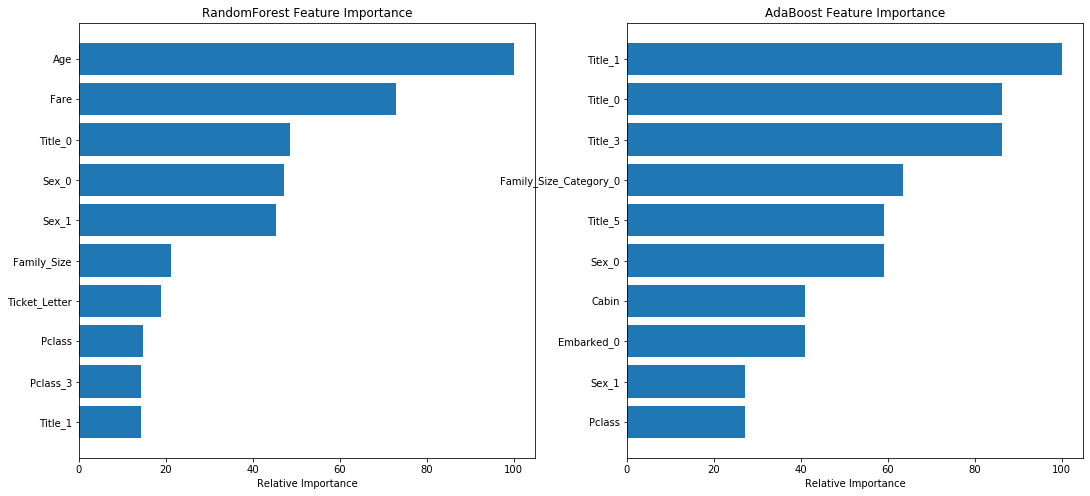

In [19]:

'''
这里用到的四种集成模型：
1.随机森林
2.AdaBoost：通过顺序的学习一些弱分类器（这些 弱分类器仅比随机好一点），然后通过加权投票得到最后的预测
3.极限树
4.GBRT：可以处理异类特征(特征的类型不一样)、具有准确的预测能力、对异常点具有鲁棒性，但很难并行

'''

def get_top_n_features(titanic_train_data_X, titanic_train_data_Y, top_n_features):

    # random forest
    rf_est = RandomForestClassifier(random_state=0)
    rf_param_grid = {'n_estimators': [500], 'min_samples_split': [2, 3], 'max_depth': [20]}
    rf_grid = model_selection.GridSearchCV(rf_est, rf_param_grid, n_jobs=25, cv=10, verbose=1)
    rf_grid.fit(titanic_train_data_X, titanic_train_data_Y)
    print('Top N Features Best RF Params:' + str(rf_grid.best_params_))
    print('Top N Features Best RF Score:' + str(rf_grid.best_score_))
    print('Top N Features RF Train Score:' + str(rf_grid.score(titanic_train_data_X, titanic_train_data_Y)))
    feature_imp_sorted_rf = pd.DataFrame({'feature': list(titanic_train_data_X),
                                          'importance': rf_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_rf = feature_imp_sorted_rf.head(top_n_features)['feature']
    print('Sample 10 Features from RF Classifier')
    print(str(features_top_n_rf[:10]))

    # AdaBoost
    ada_est =AdaBoostClassifier(random_state=0)
    ada_param_grid = {'n_estimators': [500], 'learning_rate': [0.01, 0.1]}
    ada_grid = model_selection.GridSearchCV(ada_est, ada_param_grid, n_jobs=25, cv=10, verbose=1)
    ada_grid.fit(titanic_train_data_X, titanic_train_data_Y)
    print('Top N Features Best Ada Params:' + str(ada_grid.best_params_))
    print('Top N Features Best Ada Score:' + str(ada_grid.best_score_))
    print('Top N Features Ada Train Score:' + str(ada_grid.score(titanic_train_data_X, titanic_train_data_Y)))
    feature_imp_sorted_ada = pd.DataFrame({'feature': list(titanic_train_data_X),
                                           'importance': ada_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_ada = feature_imp_sorted_ada.head(top_n_features)['feature']
    print('Sample 10 Feature from Ada Classifier:')
    print(str(features_top_n_ada[:10]))

    # ExtraTree
    et_est = ExtraTreesClassifier(random_state=0)
    et_param_grid = {'n_estimators': [500], 'min_samples_split': [3, 4], 'max_depth': [20]}
    et_grid = model_selection.GridSearchCV(et_est, et_param_grid, n_jobs=25, cv=10, verbose=1)
    et_grid.fit(titanic_train_data_X, titanic_train_data_Y)
    print('Top N Features Best ET Params:' + str(et_grid.best_params_))
    print('Top N Features Best ET Score:' + str(et_grid.best_score_))
    print('Top N Features ET Train Score:' + str(et_grid.score(titanic_train_data_X, titanic_train_data_Y)))
    feature_imp_sorted_et = pd.DataFrame({'feature': list(titanic_train_data_X),
                                          'importance': et_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_et = feature_imp_sorted_et.head(top_n_features)['feature']
    print('Sample 10 Features from ET Classifier:')
    print(str(features_top_n_et[:10]))

    # GradientBoosting
    gb_est =GradientBoostingClassifier(random_state=0)
    gb_param_grid = {'n_estimators': [500], 'learning_rate': [0.01, 0.1], 'max_depth': [20]}
    gb_grid = model_selection.GridSearchCV(gb_est, gb_param_grid, n_jobs=25, cv=10, verbose=1)
    gb_grid.fit(titanic_train_data_X, titanic_train_data_Y)
    print('Top N Features Best GB Params:' + str(gb_grid.best_params_))
    print('Top N Features Best GB Score:' + str(gb_grid.best_score_))
    print('Top N Features GB Train Score:' + str(gb_grid.score(titanic_train_data_X, titanic_train_data_Y)))
    feature_imp_sorted_gb = pd.DataFrame({'feature': list(titanic_train_data_X),
                                           'importance': gb_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_gb = feature_imp_sorted_gb.head(top_n_features)['feature']
    print('Sample 10 Feature from GB Classifier:')
    print(str(features_top_n_gb[:10]))

    # DecisionTree
    dt_est = DecisionTreeClassifier(random_state=0)
    dt_param_grid = {'min_samples_split': [2, 4], 'max_depth': [20]}
    dt_grid = model_selection.GridSearchCV(dt_est, dt_param_grid, n_jobs=25, cv=10, verbose=1)
    dt_grid.fit(titanic_train_data_X, titanic_train_data_Y)
    print('Top N Features Best DT Params:' + str(dt_grid.best_params_))
    print('Top N Features Best DT Score:' + str(dt_grid.best_score_))
    print('Top N Features DT Train Score:' + str(dt_grid.score(titanic_train_data_X, titanic_train_data_Y)))
    feature_imp_sorted_dt = pd.DataFrame({'feature': list(titanic_train_data_X),
                                          'importance': dt_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_dt = feature_imp_sorted_dt.head(top_n_features)['feature']
    print('Sample 10 Features from DT Classifier:')
    print(str(features_top_n_dt[:10]))

    # merge the three models
    features_top_n = pd.concat([features_top_n_rf, features_top_n_ada, features_top_n_et, features_top_n_gb, features_top_n_dt],
                               ignore_index=True).drop_duplicates()

    features_importance = pd.concat([feature_imp_sorted_rf, feature_imp_sorted_ada, feature_imp_sorted_et,
                                   feature_imp_sorted_gb, feature_imp_sorted_dt],ignore_index=True)

    return features_top_n , features_importance
# 将28个特征输入
feature_to_pick = 28
feature_top_n, feature_importance = get_top_n_features(titanic_train_data_X, titanic_train_data_Y, feature_to_pick)
titanic_train_data_X = pd.DataFrame(titanic_train_data_X[feature_top_n])
titanic_test_data_X = pd.DataFrame(titanic_test_data_X[feature_top_n])

# 将特征以图表的形式绘制：
rf_feature_imp = feature_importance[:10]
Ada_feature_imp = feature_importance[32:32+10].reset_index(drop=True)

# make importances relative to max importance
rf_feature_importance = 100.0 * (rf_feature_imp['importance'] / rf_feature_imp['importance'].max())
Ada_feature_importance = 100.0 * (Ada_feature_imp['importance'] / Ada_feature_imp['importance'].max())

# Get the indexes of all features over the importance threshold
rf_important_idx = np.where(rf_feature_importance)[0]
Ada_important_idx = np.where(Ada_feature_importance)[0]

# Adapted from Gradient Boosting regression
pos = np.arange(rf_important_idx.shape[0]) + .5

plt.figure(1, figsize = (18, 8))

plt.subplot(121)
plt.barh(pos, rf_feature_importance[rf_important_idx][::-1])
plt.yticks(pos, rf_feature_imp['feature'][::-1])
plt.xlabel('Relative Importance')
plt.title('RandomForest Feature Importance')

plt.subplot(122)
plt.barh(pos, Ada_feature_importance[Ada_important_idx][::-1])
plt.yticks(pos, Ada_feature_imp['feature'][::-1])
plt.xlabel('Relative Importance')
plt.title('AdaBoost Feature Importance')

plt.show()

由上图可以找出影响较高的特征。

后续即可开始进行模型的与融合了。
### 2.模型建立与融合
这里使用两层模型进行融合

第一层使用随机森林、极限树、AdaBoost、GBDT、决策树、KNN以及SVM七个模型，使用K-fold方法（推荐的GridSearch默认参数就是3-fold）进行超参数调整

第二层使用XGBoost对第一层的预测结果作为特征来对最终的结果进行预测。

#### （1）第一层模型的建立

In [20]:
# 首先建立K-fold预测方法：
'''
它将原始数据分成K组(K-Fold)，将每个子集数据分别做一次验证集，其余的K-1组子集数据作为训练集，这样会得到K个模型。
这K个模型分别在验证集中评估结果，最后的误差MSE(Mean Squared Error)加和平均就得到交叉验证误差。
交叉验证有效利用了有限的数据，并且评估结果能够尽可能接近模型在测试集上的表现，可以做为模型优化的指标使用。

可以通过K-Fold训练的训练记录下来较为优异的超参数，然后再以最优模型最优参数进行重新训练，将会取得更优结果
'''

ntrain = titanic_train_data_X.shape[0]
ntest = titanic_test_data_X.shape[0]
NFOLDS = 3 # 3次中找寻最佳结果作为后续参数
kf = KFold(n_splits = NFOLDS, random_state=None, shuffle=False)

def get_out_fold(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.fit(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

# 学习曲线的绘制


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), verbose=0):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


# train_size范围为[0，712]
# 设定交叉验证，分成10份数据集，抽出20%用于测试集
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

# 第一层的七个基础模型的训练：


rf = RandomForestClassifier(n_estimators=3000, warm_start=True, max_features='sqrt',max_depth=6,
                            min_samples_split=3, min_samples_leaf=2, n_jobs=-1, verbose=0)

ada = AdaBoostClassifier(n_estimators=2000, learning_rate=0.05)

et = ExtraTreesClassifier(n_estimators=2500, n_jobs=-1, max_depth=9, min_samples_leaf=2, verbose=0)

gb = GradientBoostingClassifier(n_estimators=2000, learning_rate=0.003,min_samples_leaf=2, max_depth=5, verbose=0)

dt = DecisionTreeClassifier(max_depth=7)

knn = KNeighborsClassifier(n_neighbors = 6)

svm = SVC(kernel='linear', C=0.025)

# 对pandas的内容进行转换：
x_train = titanic_train_data_X.values
x_test = titanic_test_data_X.values
y_train = titanic_train_data_Y.values


#### （2）第一层基本模型的调参
通过plot_learning_curve方法绘制基模型的学习曲线，来查看模型的拟合情况，并对出现过拟合或者欠拟合的模型的超参数进行调整。

这里没有进行精细的参数调整，仅依据训练结果进行了部分参数的超参数调整。

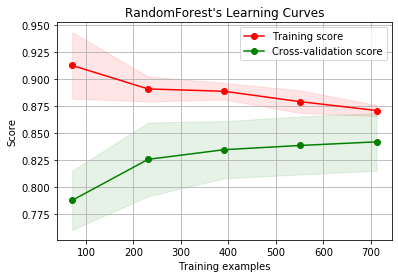

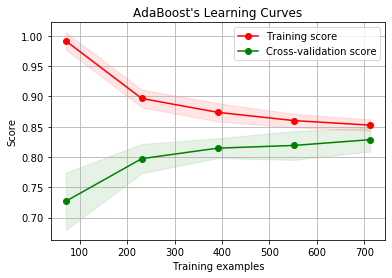

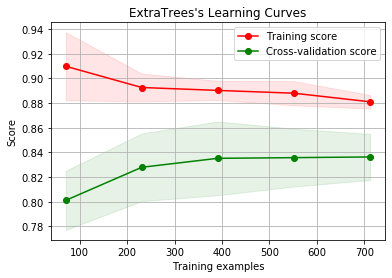

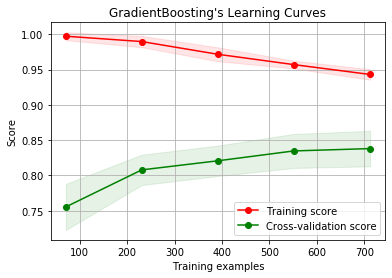

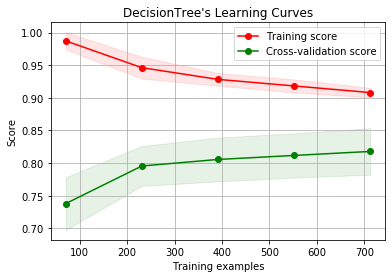

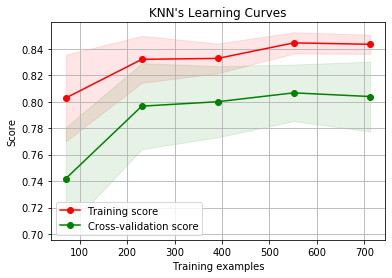

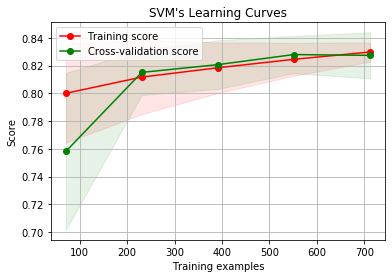

ValueError: Found array with 0 sample(s) (shape=(0, 28)) while a minimum of 1 is required.

In [21]:
title = "RandomForest's Learning Curves"
plot_learning_curve(rf, title, x_train, y_train, cv=cv,  n_jobs=4)
plt.show()

title = "AdaBoost's Learning Curves"
plot_learning_curve(ada, title, x_train, y_train, cv=cv,  n_jobs=4)
plt.show()

title = "ExtraTrees's Learning Curves"
plot_learning_curve(et, title, x_train, y_train, cv=cv,  n_jobs=4)
plt.show()

title = "GradientBoosting's Learning Curves"
plot_learning_curve(gb, title, x_train, y_train, cv=cv,  n_jobs=4)
plt.show()

title = "DecisionTree's Learning Curves"
plot_learning_curve(dt, title, x_train, y_train, cv=cv,  n_jobs=4)
plt.show()

title = "KNN's Learning Curves"
plot_learning_curve(knn,title, x_train, y_train, cv=cv,  n_jobs=4)
plt.show()

title = "SVM's Learning Curves"
plot_learning_curve(svm, title, x_train, y_train, cv=cv,  n_jobs=4)
plt.show()

# 模型训练并找最佳超参数
rf_train, rf_test = get_out_fold(rf, x_train, y_train, x_test)
ada_train, ada_test = get_out_fold(ada, x_train, y_train, x_test)
et_train, et_test = get_out_fold(et, x_train, y_train, x_test)
gb_train, gb_test = get_out_fold(gb, x_train, y_train, x_test)
dt_train, dt_test = get_out_fold(dt, x_train, y_train, x_test)
knn_train, knn_test = get_out_fold(knn, x_train, y_train, x_test)
svm_train, svm_test = get_out_fold(svm, x_train, y_train, x_test)

print("INFO:Models' Training Is Complete")

#### （3）第二层模型的构建
导入XGBoost，将上面七个基学习器的最佳结果作为训练集再次进行训练，并绘制其学习参数图。

In [ ]:
# 使用XGBoost进行预测

x_train = np.concatenate((rf_train,ada_train,et_train,gb_train,dt_train,knn_train,svm_train),axis=1)
x_test = np.concatenate((rf_test,ada_test,et_test,gb_test,dt_test,knn_test,svm_test),axis=1)

# 导入并行提升树


result = XGBClassifier( n_estimators= 2500, max_depth= 4, min_child_weight= 2, gamma=0.9, subsample=0.8,
                     colsample_bytree=0.8, objective= 'binary:logistic', nthread= -1, scale_pos_weight=1).fit(x_train, y_train)

# 绘制学习曲线
title = "XGB's Learning Curves"
plot_learning_curve(result, title, x_train, y_train, cv=cv,  n_jobs=4)
plt.show()


### 3.结果的预测与导出

In [ ]:
# 进行预测并导出数据
predictions = result.predict(x_test)
StackingSubmission = pd.DataFrame({'PassengerId': PassengerId, 'Survived': predictions})
StackingSubmission.to_csv('StackingSubmission.csv',index=False,sep=',')

五、总结与感悟
--
这场持续了接近一周的Titanic之旅到此就告一段落了。

这篇文章以前辈们对于Titanic数据集的分析为主要蓝本，佐以他们使用到的方法对应的官方API文档，最终得到了本文档。

这场旅程，让我感触最深的就是sklearn对于模型的封装、pandas的数据处理、seaborn的绘图，前人对于数据集的分析与猜测。

在这之前，我使用的各种工具包中，要么是处理数据能力很强大，要么就是数据过于简单或者很干净，完全不用洗。结果这次让我完整地经历了洗数据
、数据预处理以及特征提取————原来数据还需要进行特征提取，原来不同的特征之间还可以联系起来作为一个新的数据加入原先数据集中。

模型方面，得益于sklearn的强大的封装，模型调用很方便，而且遵循前人的脚步，也尝试了我们书本上的集成学习，将多个基学习器集成，在调参的
时候就发现了这种模式的优势————即使说个别的基学习器存在过拟合或者欠拟合的问题，但最后对集成模型的影响相比之下较小。
对于模型的训练结果，我这里采用的是plot_learning_curve的方式来判断模型的学习情况，只要是准确率特别高快到1的那种，基本上都是过拟合，尤其是
树，只要深度稍微深一些，它们就开始过拟合，但对于测试集的表现就是70%多，像这种情况就需要对他们的深度进行限制，通过不断尝试找到相对合适的超参数
但这里我没有进行特别详细的超参数调试，仅仅是做了相对粗略的调试。

最后就是无处不在的图表绘制了，在分析阶段包括特征提取都离不开图表的绘制，过去一学期或者说一年绘制的图表都没有这篇文章绘制的多，条形图、饼图、折线图
、热力图等等，基本上常用到的图表都在本文中有体现。

这场Titanic之旅就此结束，也为我这学期的机器学习课程画上了一个圆满的句号。